In [1]:
import scipy.io as sio
import numpy as np
import os
import fileinput
import plotly.graph_objs as go
import sklearn
import struct
import re
import io
import csv
import pickle
import pandas as pd
from scipy.cluster.vq import whiten
from sklearn import cluster
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn import decomposition
import matplotlib.pyplot as plt
import urllib
import tensorflow as tf
from matplotlib.backends.backend_pdf import PdfPages
import urllib3
from sklearn.cross_decomposition import CCA
import plotly.plotly as py
import http
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
import plotly.graph_objs as go
from numpy import genfromtxt
from random import shuffle
%matplotlib inline

# Get the name of the files and folders

In [2]:
def GetName(path):
    Folder = []
    r = []
    Subfolder = []
    full_path = []
    count_list = []
    for folder in os.listdir(path):
        count = 0
        Folder.append(folder)
        for subfolder in os.listdir(path+'/'+folder):
            Subfolder.append(subfolder)
            for files in os.listdir(path+'/'+folder+'/'+subfolder):
                if os.path.splitext(files)[1] == ".pts":
                    r.append(files) 
                    full_path.append(folder+'/'+subfolder+'/'+files)
                    count += 1
        count_list.append(count)
    return Folder, Subfolder, r, full_path, count_list

In [3]:
# Get what we need for each FOLD (1,2,3,4,5) for two people involved

# for FOLD_1
path = r"C:/Users/pinouche/Downloads/FOLD_1/"
Folders_Fold1, Subfolders_Fold1, Files_Fold1, Full_path_Fold1, count_list_FOLD1 = GetName(path)

In [4]:
# FOLD 2
path = r"C:/Users/pinouche/Downloads/FOLD_2/"
Folders_Fold2, Subfolders_Fold2, Files_Fold2, Full_path_Fold2, count_list_FOLD2 = GetName(path)

In [5]:
# FOLD 3
path = r"C:/Users/pinouche/Downloads/FOLD_3/"
Folders_Fold3, Subfolders_Fold3, Files_Fold3, Full_path_Fold3, count_list_FOLD3 = GetName(path)

In [6]:
# FOLD 4
path = r"C:/Users/pinouche/Downloads/FOLD_4/"
Folders_Fold4, Subfolders_Fold4, Files_Fold4, Full_path_Fold4, count_list_FOLD4 = GetName(path)

In [7]:
#FOLD 5
path = r"C:/Users/pinouche/Downloads/FOLD_5/"
Folders_Fold5, Subfolders_Fold5, Files_Fold5, Full_path_Fold5, count_list_FOLD5 = GetName(path)

In [8]:
# concat the folders above and print some information about the shapes

Folders_full = np.concatenate([Folders_Fold1, Folders_Fold2, Folders_Fold3, Folders_Fold4, Folders_Fold5])
Count_full = np.concatenate([count_list_FOLD1, count_list_FOLD2, count_list_FOLD3, count_list_FOLD4, count_list_FOLD5])
Full_path_full = np.concatenate([Full_path_Fold1, Full_path_Fold2, Full_path_Fold3, Full_path_Fold4, Full_path_Fold5])
print([Folders_full.shape, Count_full.shape, Full_path_full.shape])

[(73,), (73,), (213072,)]


# Load the data

In [9]:
# Retrieve the data for FOLD1

Full_data_x = pickle.load( open( "Full_data_x.p", "rb" ))
print(Full_data_x.shape)

(213072, 68, 2)


In [10]:
# Retrieve the data for FOLD1

data_x = pickle.load( open( "data_x.p", "rb" ))
print(data_x.shape)

(106536, 196)


In [11]:
# Retrieve the annotations

annotation_vector_Two = pickle.load( open( "annotation_vector_Two.p", "rb" ))
print(annotation_vector_Two.shape)

(73,)


# Perform PCA separately on the participants

In [12]:
# get the participants separated

from sklearn import preprocessing

data_participant1 = data_x[:,:98]
data_participant2 = data_x[:,98:]
participant1_scaled = preprocessing.scale(data_participant1)
participant2_scaled = preprocessing.scale(data_participant2)
data_x = preprocessing.scale(data_x)

C:\Users\pinouche\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning:

Data with input dtype <U7 was converted to float64 by the scale function.



In [13]:
# Perform PCA on each

pca = PCA(n_components = 10)
PCA_participant1 = pca.fit_transform(participant1_scaled)
print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)) 
PCA_participant2 = pca.fit_transform(participant2_scaled)
print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)) 

[  5.59370901e-01   4.08817189e-01   1.67664210e-02   9.53308206e-03
   2.28489609e-03   1.10068091e-03   7.28768422e-04   3.46924852e-04
   2.77898006e-04   2.13986759e-04] 0.999440748497
[  5.19577145e-01   4.48480917e-01   1.77745617e-02   9.34738446e-03
   1.95069552e-03   9.53343678e-04   5.88331534e-04   3.24681178e-04
   2.52574308e-04   2.03902518e-04] 0.999453536925


In [14]:
# concatenate the PCA data

PCA_full_x = np.concatenate([PCA_participant1,PCA_participant2], axis = 1)
print(PCA_full_x.shape)

(106536, 20)


# Smooth the response data

In [571]:
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

def SmoothResponse(response_list = annotation_vector_Two):
    length = len(annotation_vector_Two)
    gauss_kernel_40 = Gaussian1DKernel(75)
    gauss_kernel_50 = Gaussian1DKernel(50)
    gauss_kernel_75 = Gaussian1DKernel(75)
    gauss_kernel_100 = Gaussian1DKernel(100)
    annotation_RBF40 = []
    annotation_RBF50 = []
    annotation_RBF75 = []
    annotation_RBF100 = []
    for index in range(length):
        response_list[index] = np.reshape(response_list[index], (response_list[index].shape[0],))
        
        Ann40 = convolve(response_list[index], gauss_kernel_40)
        Ann40[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann40 = np.reshape(Ann40, (response_list[index].shape[0],1))
        
        Ann50 = convolve(response_list[index], gauss_kernel_50)
        Ann50[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann50 = np.reshape(Ann50, (response_list[index].shape[0],1))
        
        Ann75 = convolve(response_list[index], gauss_kernel_75)
        Ann75[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann75 = np.reshape(Ann75, (response_list[index].shape[0],1))
        
        Ann100 = convolve(response_list[index], gauss_kernel_100)
        Ann100[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann100 = np.reshape(Ann100, (response_list[index].shape[0],1))
    
        annotation_RBF40.append(Ann40)
        annotation_RBF50.append(Ann50)
        annotation_RBF75.append(Ann75)
        annotation_RBF100.append(Ann100)
           
    return annotation_RBF40, annotation_RBF50, annotation_RBF75, annotation_RBF100 

In [572]:
annotation_RBF40, annotation_RBF50, annotation_RBF75, annotation_RBF100 = SmoothResponse()
print([len(annotation_RBF40), len(annotation_RBF50), len(annotation_RBF75), len(annotation_RBF100)])
print([annotation_RBF40[0].shape, annotation_RBF50[0].shape, annotation_RBF75[0].shape, annotation_RBF100[0].shape])

[73, 73, 73, 73]
[(11155, 1), (11155, 1), (11155, 1), (11155, 1)]


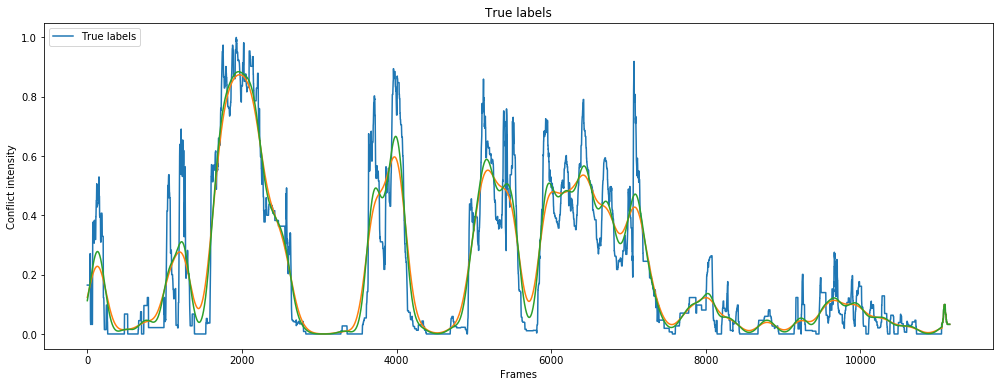

In [573]:
# Plot a few video sequences to see if smoothing is justified

fig = plt.figure(figsize=(17, 6))
plt.plot(annotation_vector_Two[0])
plt.plot(annotation_RBF100[0])
plt.plot(annotation_RBF40[0])
plt.title('True labels')
plt.ylabel('Conflict intensity')
plt.xlabel('Frames')
plt.legend(['True labels'], loc='upper left')
plt.show()

# Prepare data to feed into NN

In [585]:
def Makelist(data,Count):
    Count = Count/2
    list_data = []
    ball = 0
    for index in range(0,len(Count)):
        list_data.append(data[ball:(ball+int(Count[index])),:])
        ball += int(Count[index])
    return(np.asarray(list_data))

In [587]:
list_data_x = Makelist(data_x, Count_full)

In [654]:
# put the things into FOLDS

def DoFOLDS(list_data, annotation_list_smooth, annotation_list, num_folder1=len(Folders_Fold1), num_folder2=len(Folders_Fold2), num_folder3=len(Folders_Fold3), num_folder4=len(Folders_Fold4), num_folder5=len(Folders_Fold5)):
    Fold1 = []
    Fold2 = []
    Fold3 = []
    Fold4 = []
    Fold5 = []
    Fold1_y_smooth = []
    Fold2_y_smooth = []
    Fold3_y_smooth = []
    Fold4_y_smooth = []
    Fold5_y_smooth = []
    Fold1_y = []
    Fold2_y = []
    Fold3_y = []
    Fold4_y = []
    Fold5_y = []
    
    for index in range(num_folder1):
        Fold1.append(list_data[index])
        Fold1_y_smooth.append(annotation_list_smooth[index])
        Fold1_y.append(annotation_list[index])
    for index in range(num_folder1, num_folder1+num_folder2):
        Fold2.append(list_data[index])
        Fold2_y_smooth.append(annotation_list_smooth[index])
        Fold2_y.append(annotation_list[index])
    for index in range(num_folder1+num_folder2,num_folder1+num_folder2+num_folder3):
        Fold3.append(list_data[index])
        Fold3_y_smooth.append(annotation_list_smooth[index])
        Fold3_y.append(annotation_list[index])
    for index in range(num_folder1+num_folder2+num_folder3,num_folder1+num_folder2+num_folder3+num_folder4):
        Fold4.append(list_data[index])
        Fold4_y.append(annotation_list[index])
        Fold4_y_smooth.append(annotation_list_smooth[index])
    for index in range(num_folder1+num_folder2+num_folder3+num_folder4,num_folder1+num_folder2+num_folder3+num_folder4+num_folder5):
        Fold5.append(list_data[index])
        Fold5_y_smooth.append(annotation_list_smooth[index])
        Fold5_y.append(annotation_list[index])
    
    assert (len(Fold1)+len(Fold2)+len(Fold3)+len(Fold4)+len(Fold5)) == 73
    
    return Fold1, Fold2, Fold3, Fold4, Fold5, Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth, Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y

Fold1, Fold2, Fold3, Fold4, Fold5, Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth, Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_5 = DoFOLDS(list_data_x, annotation_RBF40, annotation_vector_Two)

In [655]:
#Test number must be either 1,2,3,4,5

def MakeTrainValTest(test_number, Fold1=Fold1, Fold2=Fold2, Fold3=Fold3, Fold4=Fold4, Fold5=Fold5, Fold1_y=Fold1_y, Fold2_y=Fold2_y, Fold3_y=Fold3_y, Fold4_y=Fold4_y, Fold5_y=Fold5_y, Fold1_y_smooth=Fold1_y_smooth, Fold2_y_smooth=Fold2_y_smooth, Fold3_y_smooth=Fold3_y_smooth, Fold4_y_smooth=Fold4_y_smooth, Fold5_y_smooth=Fold5_y_smooth):
    list_Folds = list([Fold1, Fold2, Fold3, Fold4, Fold5])
    list_Folds_y = list([Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y])
    list_Folds_y_smooth = list([Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth])
    number_val_test = []
    Train_list = []
    Val_list = []
    Test_list = []
    Train_list_y = []
    Val_list_y = []
    Test_list_y = []
    length = 0
    
    Test_list = list_Folds[test_number-1]
    Test_list_y = list_Folds_y[test_number-1]
    number_val_test.append(test_number-1)
    
    if(test_number == 1):
        Val_list = list_Folds[4]
        Val_list_y = list_Folds_y[4]
        number_val_test.append(4)
    else:
        Val_list = list_Folds[test_number-2]
        Val_list_y = list_Folds_y[test_number-2]
        number_val_test.append(test_number-2)
    
    for index in range(5):
        length = len(list_Folds[index])
        if(index != number_val_test[0] and index != number_val_test[1]):
            for index2 in range(length):
                Train_list.append(list_Folds[index][index2])
                Train_list_y.append(list_Folds_y_smooth[index][index2])       
    
    return Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y 

In [693]:
Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y = MakeTrainValTest(1)

In [694]:
# Enter the test sequence number and the function returns the corresponding training and validation sets.

#def Dotraining(Mylist, y_array, test_number, validation_number):
    
#    train_data = []
#    val_data = []
#    test_data = []
#    train_y = []
#    val_y = []
#    test_y = []
#    print(len(Mylist))
    #indices = np.array([x for x in range(len(Mylist))])
    
#    for index in range(0,len(Mylist)):
#        l = Mylist
#        ll = y_array
#        if(test_number != index):
            
#            val_y.append(ll[index])
#            test_y.append(ll[test_number])
#            val_data.append(l[index])
#            test_data.append(l[test_number])
            
#            trainn = [x for i,x in enumerate(Mylist) if(i!=index and i!=test_number)]
#            train_data.append(trainn)
            
#            trainn_y = [x for i,x in enumerate(y_array) if(i!=index and i!=test_number)]
#            train_y.append(trainn_y)
    
#    Train_data_concat = np.asarray(train_data[validation_number][0])        
#    for index in range(1, len(train_data)-1):
#        Train_data_concat = np.concatenate([Train_data_concat, np.asarray(train_data[validation_number][index])])
        
#    Train_y_concat = np.asarray(train_y[validation_number][0])        
#    for index in range(1, len(train_y)-1):
#        Train_y_concat = np.concatenate([Train_y_concat, np.asarray(train_y[validation_number][index])])
#    
#    Train_data = np.asarray(train_data[validation_number])
#    Train_y = np.asarray(train_y[validation_number])
#        
#    val_data = np.asarray(val_data[validation_number])
#    test_data = np.asarray(test_data[validation_number])
#    
#    val_y = np.asarray(val_y[validation_number])
#    test_y = np.asarray(test_y[validation_number])
#            
#    return Train_data, val_data, test_data, Train_y, val_y, test_y, Train_y_concat, Train_data_concat

In [695]:
#_, val_x, test_x, _, val_y, test_y, Train_y_concat, Train_data_concat = Dotraining(list_data_x, annotation_vector_Two, 71, 71)
#train_x, _, _, train_y_smooth, _, _, Train_y_concat_smoothed, _ = Dotraining(list_data_x, annotation_RBF40, 71, 71)

In [681]:
#print(type(train_x), type(train_y_smooth))
#print(train_x.shape, train_y_smooth.shape)
#print(val_x.shape, test_x.shape, val_y.shape, test_y.shape)
#print(Train_y_concat.shape, Train_data_concat.shape)

# Neural Net First Method: Do it on the concatenated data for all the participants

In [756]:
epsilon = 0.001
beta = 0.02
batch_size = 32
#hidden_size1 = 32
#hidden_size2 = 32
#learning_rate = 0.00001
n_epochs = 60

In [757]:
def NeuralNetMethod1(train_x, train_y, val_x, val_y, learning_rate, input_size, hidden_size1, hidden_size2, batch_size = batch_size,  n_epochs=n_epochs, epsilon = epsilon, Train_y_concat=Train_y_concat, Train_data_concat=Train_data_concat):
    
    
    X = tf.placeholder(shape = [None, input_size], dtype = tf.float32, name = "input")
    y = tf.placeholder(shape = [None, 1], dtype = tf.float32, name = "label")
    
    # Layer 1
    W_input = tf.Variable(tf.random_normal(shape = [input_size, hidden_size1], stddev = 0.1), name = "weights_input", trainable = True)
    #b_input = tf.Variable(tf.random_normal(shape = [1, hidden_size1], stddev = 0.1), name ="network_bias", trainable = True)
    
    hidden_units_1 = tf.matmul(X, W_input)
    batch_mean1, batch_var1 = tf.nn.moments(hidden_units_1,[0])
    scale1 = tf.Variable(tf.ones([hidden_size1]))
    beta1 = tf.Variable(tf.zeros([hidden_size1]))
    BN1 = tf.nn.batch_normalization(hidden_units_1,batch_mean1, batch_var1, beta1, scale1, epsilon)
    relu_hidden_1 = tf.nn.sigmoid(BN1, name = "ReLu_hidden_layer")
    
    # Layer 2
    
    W_hidden_1 = tf.Variable(tf.random_normal(shape = [hidden_size1, hidden_size2], stddev = 0.1), name ="weights_hidden1", trainable = True)
    #h_drop1 = tf.nn.dropout(relu_hidden_1, 0.7)
    hidden_units_2 = tf.matmul(relu_hidden_1, W_hidden_1)
    batch_mean2, batch_var2 = tf.nn.moments(hidden_units_2,[0])
    scale2 = tf.Variable(tf.ones([hidden_size2]))
    beta2 = tf.Variable(tf.zeros([hidden_size2]))
    BN2 = tf.nn.batch_normalization(hidden_units_2, batch_mean2, batch_var2, beta2, scale2, epsilon)
    relu_hidden_2 = tf.nn.relu(BN2, name = "Relu_hidden_layer2")
    
    # Output layer
    W_hidden_3 = tf.Variable(tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), name ="weights_hidden2", trainable = True)
    
    # For mean square loss
    #h_drop2 = tf.nn.dropout(relu_hidden_2, 0.95)
    logits = tf.matmul(relu_hidden_2, W_hidden_3)
    mean_squared = tf.losses.mean_squared_error(predictions = logits, labels = y)
     
    
    regularizer = tf.norm(W_input, ord = 2)
    regularizer1 = tf.norm(W_hidden_1, ord = 2)
    #regularizer2 = tf.norm(W_hidden_2, ord = 2)
    regularizer3 = tf.norm(W_hidden_3, ord = 2)
    loss = tf.reduce_mean(mean_squared + beta * (regularizer+regularizer1+regularizer3))
    
    global_step = tf.Variable(0, trainable=False)
    boundaries = [n_epochs]
    values = [learning_rate, learning_rate/2]
    learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    val_loss = []
    pred_val = []
    for i in range(1, n_epochs+1):
        train_loss_list = []
        
        #indices = list(range(train_x.shape[0]))
        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            n_batches = int(train_x[index1].shape[0]/batch_size)
            
            for index in range(n_batches):
                X_batch = train_x[index1][index*batch_size:index*batch_size+batch_size,:]
                Y_batch = train_y[index1][index*batch_size:index*batch_size+batch_size,:]
                _, Loss = sess.run([optimizer, loss], feed_dict = {X: X_batch, y: Y_batch})
                train_loss += Loss
            train_loss /= n_batches
            train_loss_list.append(train_loss)
        train_loss_sum = sum(train_loss_list)/len(train_x)
            
    
        if(i % 2 == 0):
            total_loss = 0
            
            for index in range(len(val_x)):
                X_batch = val_x[index]
                Y_batch = np.reshape(val_y[index], (val_y[index].shape[0],1))
                loss_batch, logits_batch = sess.run([loss, logits], feed_dict = {X: X_batch, y: Y_batch})
                #MSE_loss = tf.losses.mean_squared_error(labels = Y_batch, predictions = logits_batch)
                if(i == n_epochs):
                    pred_val = logits_batch
                    pred_val = np.asarray(pred_val)
                    
                total_loss += loss_batch
                
            total_loss /= len(val_x)
            print("Step: " + str(i) + " MSE val loss {0}".format(total_loss) + " MSE training loss " + str(train_loss_sum))
            val_loss.append(total_loss)
            
            #X_batch = val_x
            #Y_batch = np.reshape(val_y, (val_y.shape[0],1))
            #loss_batch, logits_batch = sess.run([loss, logits], feed_dict = {X: X_batch, y: Y_batch})
            
    pred_train = []
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))

    Train_y_concat = np.reshape(Train_y_concat, (Train_y_concat.shape[0],1))
    loss_batch, logits_batch = sess.run([loss, logits], feed_dict = {X: Train_data_concat, y: Train_y_concat})
    pred_train = logits_batch
       
    sess.close()
    tf.reset_default_graph()
    return lowest_loss, min_index, total_loss, pred_val, pred_train

In [758]:
# Best so far: 32, 16, 0.0001, beta= 0.02 (0.0773) for test_number = 1

#lowest_loss_list = []

#for index in range(5):
#    Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y = MakeTrainValTest(index+1)
#    lowest_loss, min_index, loss, predictions_val, predictions_train = NeuralNetMethod1(Train_list, Train_list_y, Val_list, Val_list_y, 0.0001, 196,64, 16)
#    lowest_loss_list.append(lowest_loss)

lowest_loss, min_index, loss, predictions_val, predictions_train = NeuralNetMethod1(Train_list, Train_list_y, Val_list, Val_list_y, 0.0001, 196, 32, 32)

Step: 2 MSE val loss 0.2632348807528615 MSE training loss 0.277642726351
Step: 4 MSE val loss 0.21760025341063738 MSE training loss 0.22659133639
Step: 6 MSE val loss 0.178385348059237 MSE training loss 0.185036513838
Step: 8 MSE val loss 0.16473685717210174 MSE training loss 0.15426516553
Step: 10 MSE val loss 0.12356528453528881 MSE training loss 0.128361552097
Step: 12 MSE val loss 0.10490689147263765 MSE training loss 0.10671795492
Step: 14 MSE val loss 0.09419901622459292 MSE training loss 0.0965507878381
Step: 16 MSE val loss 0.10498552909120917 MSE training loss 0.0921310205063
Step: 18 MSE val loss 0.09042183356359601 MSE training loss 0.088484656142
Step: 20 MSE val loss 0.08953631483018398 MSE training loss 0.088215714548
Step: 22 MSE val loss 0.0923487483523786 MSE training loss 0.0863360327993
Step: 24 MSE val loss 0.08876575133763254 MSE training loss 0.0873364597004
Step: 26 MSE val loss 0.09070942690595984 MSE training loss 0.0856115280041
Step: 28 MSE val loss 0.0812355

In [ ]:
# function to plot true vs predicted

def plotTrueVPred(true_values, predicted_values):
    fig = plt.figure(figsize=(17, 6))
    plt.plot(predicted_values)
    plt.plot(true_values)
    plt.title('Model prediction vs real labels')
    plt.ylabel('Conflict intensity')
    plt.xlabel('Frames')
    plt.legend(['Predicted labels', 'True labels'], loc='upper left')
    plt.show()
    #fig.savefig('newfiguseless.png', bbox_inches='tight')
    
plotTrueVPred(val_y, predictions_val)

In [256]:
# Compute ICC and pearson cor coeff

from scipy.stats.stats import pearsonr

# Correlation for the validation set
print(pearsonr(np.reshape(val_y, (val_y.shape[0],)), np.reshape(predictions_val, (predictions_val.shape[0],))))


(-0.22662165936925435, 1.3354292956580308e-10)


# Method with the LSTM for the two participants to be used in another LSTM

In [33]:
def ManyToOne(x_seq, y_seq, window_size, val_boolean):
    list_x = []
    list_y = []
    list_x_shuffled = []
    list_y_shuffled = []
    assert len(x_seq) == len(y_seq)
    lenght_new_seq = len(x_seq)-window_size+1
    
    for index in range(lenght_new_seq):
        list_x.append(x_seq[index:window_size+index,:])
        list_y.append(y_seq[window_size-1+index])
    
    if(val_boolean == 0):
        indices = list(range(lenght_new_seq))
        shuffle(indices)
    
        for element in indices:
            list_x_shuffled.append(list_x[element])
            list_y_shuffled.append(list_y[element])
            
    elif(val_boolean == 1):
        list_x_shuffled = list_x
        list_y_shuffled = list_y
        
    return list_x_shuffled, list_y_shuffled  

In [34]:
epsilon = 0.001
beta = 0.05
hidden_size = 16
hidden_size1 = 8
hidden_size2 = 8
learning_rate = 0.00001
n_epochs = 70

In [35]:
# Network Parameters particular to the LSTM. We feed the person 1 and then the person 2

num_input1 = 10 # num_of_features
num_input2 = 16 # size of output of first LSTM (i.e size of input of second LSTM)
timesteps_1 = 2 # timesteps for the number of participants (first LSTM)
window_size = 10 #(25 frames = 1 sec)
timesteps_2 = window_size
batch_size = timesteps_2

In [36]:
def LSTM(train_x, train_y, val_x, val_y, learning_rate=learning_rate, batch_size=batch_size,  n_epochs=n_epochs, num_input1=num_input1, num_input2=num_input2, timesteps_1=timesteps_1, timesteps_2=timesteps_2):

    with tf.variable_scope('data'):
        prob = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [batch_size, timesteps_1, num_input1], dtype = tf.float32, name = "input")
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [1,1], dtype = tf.float32, name = "label_annotation")

    with tf.variable_scope('lstm_cell_1'):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, forget_bias = 1.0)
        lstm_outputs, lstm_states = tf.contrib.rnn.static_rnn(lstm_cell, X, dtype = tf.float32)
        lstm_outputs[-1] = tf.nn.dropout(lstm_outputs[-1], prob)
        
        batch_mean1, batch_var1 = tf.nn.moments(lstm_outputs[-1],[0])
        scale1 = tf.Variable(tf.ones([hidden_size]))
        beta1 = tf.Variable(tf.zeros([hidden_size]))
        BN1 = tf.nn.batch_normalization(lstm_outputs[-1],batch_mean1, batch_var1, beta1, scale1, epsilon)
        
        BN1 = tf.reshape(BN1, [1, timesteps_2, hidden_size])
        BN1 = tf.unstack(BN1, timesteps_2, 1)
        
    ################## THIS IS THE ADDED PART
    
    with tf.variable_scope('lstm_cell_2'):
        lstm_cell2 = tf.nn.rnn_cell.BasicLSTMCell(hidden_size1, forget_bias = 1.0)
        lstm_outputs1, lstm_states1 = tf.contrib.rnn.static_rnn(lstm_cell2, BN1, dtype = tf.float32)
        lstm_outputs1[-1] = tf.nn.dropout(lstm_outputs1[-1], prob)
        
        batch_mean2, batch_var2 = tf.nn.moments(lstm_outputs1[-1],[0])
        scale2 = tf.Variable(tf.ones([hidden_size1]))
        beta2 = tf.Variable(tf.zeros([hidden_size1]))
        BN2 = tf.nn.batch_normalization(lstm_outputs1[-1],batch_mean2, batch_var2, beta2, scale2, epsilon) 
            
    ##################
        
    with tf.variable_scope('Fully_connected_Layer'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size1, hidden_size2], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_1 = tf.nn.relu(tf.matmul(BN2, W_hidden))
        batch_mean3, batch_var3 = tf.nn.moments(hidden_1, [0])
        scale3 = tf.Variable(tf.ones([hidden_size2]))
        beta3 = tf.Variable(tf.zeros([hidden_size2]))
        BN3 = tf.nn.batch_normalization(hidden_1, batch_mean3, batch_var3, beta3, scale3, epsilon)
           
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), name = "noreg", trainable = True)
        logits = tf.matmul(BN3, W_hidden2)
        loss =  tf.losses.mean_squared_error(predictions = logits, labels = y)
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "Bias" in tf_var.name))
        loss += l2
        

    global_step = tf.Variable(0, trainable=False)
    boundaries = [50]
    values = [learning_rate, learning_rate/2]
    learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    print(sess.run(tf.shape(X_or)))
    print(sess.run(tf.shape(X)))
    print(sess.run(tf.shape(BN1)))
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    val_loss = []
    pred_val = []
    for i in range(1, n_epochs+1):
        train_loss = 0

        indices = list(range(train_x.shape[0]))
        shuffle(indices)
        for index1 in indices:
            list_x, list_y = ManyToOne(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            #n_batches = int(train_x[index1].shape[0]/batch_size)
            # for index in range(n_batches):
            
            for index in range(len(list_x)):
                
                #X_batch = train_x[index1][index*batch_size:index*batch_size+batch_size,:]
                #X_batch = np.reshape(X_batch, (batch_size, 2, 10))
                #Y_batch = train_y[index1][index*batch_size:index*batch_size+batch_size,:]
                
                X_batch = np.reshape(list_x[index], (batch_size, 2, num_input1))
                Y_batch = np.reshape(list_y[index], (1,1))
                
                _, Loss = sess.run([train_op, loss], feed_dict = {X_or: X_batch, y: Y_batch, prob: 0.9})
                train_loss += Loss
            train_loss /= len(list_x)
        
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):
           
            total_loss = 0
            list_x_val, list_y_val = ManyToOne(val_x, val_y, window_size = window_size, val_boolean = 1)
            
            pred_val = []
            for index in range(len(list_x_val)):
                X_batch = np.reshape(list_x_val[index], (batch_size, 2, num_input1))
                Y_batch = np.reshape(list_y_val[index], (1,1))
                loss_batch, logits_batch = sess.run([loss, logits], feed_dict = {X_or: X_batch, y: Y_batch, prob: 1})
                
                #MSE_loss = tf.losses.mean_squared_error(labels = Y_batch, predictions = logits_batch)
                
                if(i == n_epochs):
                    pred_val.append(logits_batch)
                
                total_loss += loss_batch
                
            total_loss /= len(list_x_val)
            print("Step: " + str(i) + " MSE val loss {0}".format(total_loss) + " MSE training loss " + str(train_loss / i))
            val_loss.append(total_loss)
        
    pred_val = np.asarray(pred_val)
                
            #X_batch = val_x
            #Y_batch = np.reshape(val_y, (val_y.shape[0],1))
            #loss_batch, logits_batch = sess.run([loss, logits], feed_dict = {X_or: X_batch, y: Y_batch})
            #MSE_loss = tf.losses.mean_squared_error(labels = Y_batch, predictions = logits_batch)
            #total_loss = sess.run(MSE_loss)
            #print("Step: " + str(i) + " MSE val loss {0}".format(total_loss) + " MSE training loss " + str(train_loss / i))
            #val_loss.append(total_loss)
            #if(i == n_epochs):
            #    pred_val = logits_batch
            #    pred_val = np.asarray(pred_val)
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
    # Implement early stopping later for the best method 
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))

    sess.close()
    tf.reset_default_graph()
    writer.close()

    return lowest_loss, min_index, total_loss, pred_val

In [95]:
lowest_loss, min_index, total_loss, pred_val = LSTM(train_x, train_y_smooth, val_x, val_y)

[10  2 10]
[ 2 10 10]
[10  1 16]
Epoch 1 done.
Step: 1 MSE val loss 0.1395857336715074 MSE training loss 0.0445978812042
Epoch 2 done.
Step: 2 MSE val loss 0.11927696357659247 MSE training loss 0.0612008390137
Epoch 3 done.
Step: 3 MSE val loss 0.12968644860762324 MSE training loss 0.0147509779107
Epoch 4 done.
Step: 4 MSE val loss 0.1104735650829625 MSE training loss 0.0110027508373
Epoch 5 done.
Step: 5 MSE val loss 0.11398020513936047 MSE training loss 0.0105898179585
Epoch 6 done.
Step: 6 MSE val loss 0.1097722743544023 MSE training loss 0.012895634655
Epoch 7 done.
Step: 7 MSE val loss 0.12642002614337355 MSE training loss 0.011574872709


KeyboardInterrupt: 

In [ ]:
# function to plot true vs predicted

def plotTrueVPred(true_values, predicted_values):
    fig = plt.figure(figsize=(17, 6))
    plt.plot(predicted_values)
    plt.plot(true_values)
    plt.title('Model prediction vs real labels')
    plt.ylabel('Conflict intensity')
    plt.xlabel('Frames')
    plt.legend(['Predicted labels', 'True labels'], loc='upper left')
    plt.show()
    #fig.savefig('newfiguseless.png', bbox_inches='tight')
    
plotTrueVPred(val_y, predictions_val)

In [ ]:
print(pearsonr(np.reshape(val_y, (val_y.shape[0],)), np.reshape(predictions_val, (predictions_val.shape[0],))))

In [720]:
tf.reset_default_graph()

# Only one stacked LSTM (regular way)

In [721]:
timesteps_1 = 2
window_size = timesteps_1
batch_size = 1
n_epochs = 40

# Hidden layer for the LSTMs
hidden_size = 32
hidden_size1 = 32
# Hidden size for the fully connected layer
hidden_size2 = 8

num_input = 196
epsilon = 0.001
beta = 0.02
learning_rate = 0.000005

# NOTE: You usually need to pass all outputs to the next RNN layer or the last output for the last RNN layer. 
# To get the last output you can use output[:,-1,:].

In [722]:
def LSTM(train_x, train_y, val_x, val_y, learning_rate=learning_rate, batch_size=batch_size,  n_epochs=n_epochs, num_input=num_input, timesteps_1=timesteps_1):


    with tf.variable_scope('data'):
        prob = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [batch_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [batch_size,1], dtype = tf.float32, name = "label_annotation")
        
    with tf.variable_scope('lstm_cell_1'):
        
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size, hidden_size1]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs, lstm_state =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=X,dtype=tf.float32)
        
        #lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, forget_bias = 1.0)
        #lstm_outputs, lstm_states = tf.contrib.rnn.static_rnn(lstm_cell, X, dtype = tf.float32)
        lstm_outputs[-1] = tf.nn.dropout(lstm_outputs[-1], prob)
        
        batch_mean1, batch_var1 = tf.nn.moments(lstm_outputs[-1],[0])
        scale1 = tf.Variable(tf.ones([hidden_size1]))
        beta1 = tf.Variable(tf.zeros([hidden_size1]))
        BN1 = tf.nn.batch_normalization(lstm_outputs[-1],batch_mean1, batch_var1, beta1, scale1, epsilon)

    ##################
        
    with tf.variable_scope('Fully_connected_Layer'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size1, hidden_size2], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_1 = tf.nn.relu(tf.matmul(BN1, W_hidden))
        batch_mean3, batch_var3 = tf.nn.moments(hidden_1, [0])
        scale3 = tf.Variable(tf.ones([hidden_size2]))
        beta3 = tf.Variable(tf.zeros([hidden_size2]))
        BN3 = tf.nn.batch_normalization(hidden_1, batch_mean3, batch_var3, beta3, scale3, epsilon)
           
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), name = "noreg", trainable = True)
        logits = tf.matmul(BN3, W_hidden2)
        loss =  tf.losses.mean_squared_error(predictions = logits, labels = y)
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "Bias" in tf_var.name))
        loss += l2
        

    global_step = tf.Variable(0, trainable=False)
    boundaries = [50]
    values = [learning_rate, learning_rate/2]
    learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    print(sess.run(tf.shape(X_or)))
    print(sess.run(tf.shape(X)))
    print(sess.run(tf.shape(BN1)))
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    val_loss = []
    pred_val = []
    for i in range(1, n_epochs+1):
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToOne(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (batch_size, window_size, num_input))
                Y_batch = np.reshape(list_y[index], (1,1))
                
                _, Loss = sess.run([train_op, loss], feed_dict = {X_or: X_batch, y: Y_batch, prob: 0.5})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):
           
            total_loss_list = []
            for index in range(len(val_x)):
                total_loss = 0
                list_x_val, list_y_val = ManyToOne(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    pred_val = []
                    X_batch = np.reshape(list_x_val[index1], (batch_size, window_size, num_input))
                    Y_batch = np.reshape(list_y_val[index1], (1,1))
                    loss_batch, logits_batch = sess.run([loss, logits], feed_dict = {X_or: X_batch, y: Y_batch, prob: 1})
                
                    if(i == n_epochs):
                        pred_val.append(logits_batch)
                
                    total_loss += loss_batch
                
                total_loss /= len(list_x_val)
                total_loss_list.append(total_loss)
            val_loss_sum = sum(total_loss_list)/len(val_x)
            print("Step: " + str(i) + " MSE val loss {0}".format(total_loss) + " MSE training loss " + str(train_loss_sum))
            val_loss.append(val_loss_sum)
        
    pred_val = np.asarray(pred_val)
          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
    # Implement early stopping later for the best method 
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))

    sess.close()
    tf.reset_default_graph()
    writer.close()

    return lowest_loss, min_index, total_loss, pred_val

In [723]:
lowest_loss, min_index, total_loss, pred_val = LSTM(Train_list, Train_list_y, Val_list, Val_list_y)

[  1   2 196]
[  2   1 196]
[ 1 64]
Epoch 1 done.
Step: 1 MSE val loss 0.4046078091500064 MSE training loss 1.92514846396
Epoch 2 done.
Step: 2 MSE val loss 0.10603897867386392 MSE training loss 0.135611143769
Epoch 3 done.
Step: 3 MSE val loss 0.09892220687650052 MSE training loss 0.0746320215407
Epoch 4 done.
Step: 4 MSE val loss 0.09945160714152176 MSE training loss 0.0744397514848
Epoch 5 done.
Step: 5 MSE val loss 0.10353302892485304 MSE training loss 0.0745680414688
Epoch 6 done.
Step: 6 MSE val loss 0.09606804125923127 MSE training loss 0.0728380405706
Epoch 7 done.
Step: 7 MSE val loss 0.09726229575531307 MSE training loss 0.0719718426118
Epoch 8 done.
Step: 8 MSE val loss 0.10670472053741967 MSE training loss 0.0733018327199
Epoch 9 done.
Step: 9 MSE val loss 0.10851754413942254 MSE training loss 0.0714321725338


KeyboardInterrupt: 

In [ ]:
# function to plot true vs predicted

def plotTrueVPred(true_values, predicted_values):
    fig = plt.figure(figsize=(17, 6))
    plt.plot(predicted_values)
    plt.plot(true_values)
    plt.title('Model prediction vs real labels')
    plt.ylabel('Conflict intensity')
    plt.xlabel('Frames')
    plt.legend(['Predicted labels', 'True labels'], loc='upper left')
    plt.show()
    #fig.savefig('newfiguseless.png', bbox_inches='tight')
    
plotTrueVPred(val_y, predictions_val)